# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [ ]:
# Download the data
if not os.path.exists('/content/carseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/carseq.npy -O /content/carseq.npy
if not os.path.exists('/content/girlseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/girlseq.npy -O /content/girlseq.npy

# Q2.1: Theory Questions (5 points)
Please refer to the handout for the detailed questions.

## Q2.1.1: What is $\frac{\partial \mathbf{W}(\mathbf{x};\mathbf{p})}{\partial \mathbf{p}^{T}}$? (**Hint**: It should be a 2x2 matrix)

===== your answer here! =====

The warp function \(W(x; p) = x + p\) maps a pixel coordinate \(x = [x, y]^T\) to a new coordinate \(x' = [x', y']^T\) by adding the offset \(p = [p_x, p_y]^T\). To find the derivative of \(W(x; p)\) with respect to \(p\), denoted as \(\frac{\partial W(x; p)}{\partial p^T}\), we differentiate the warp function with respect to \(p\).

Given \(W(x; p) = x + p\), where \($x = [x, y]^T$\) and \($p = [p_x, p_y]^T$\), we can express this as:
\[
$x' = x + p_x$
\]

\[
$y' = y + p_y$
\]

<break>
<break>

The derivative of \(W(x; p)\) with respect to \(p\), arranged as a transposed Jacobian matrix would be:


$$
\frac{\partial W(x; p)}{\partial p^T} = \frac{\partial [x', y']}{\partial [p_x, p_y]}
$$




This results in a matrix where each element represents the partial derivative of the output coordinates $[x', y']$ with respect to each element of $p = [p_x, p_y]$:


$$
\frac{\partial W(x; p)}{\partial p^T} = \begin{bmatrix} \frac{\partial x'}{\partial p_x} & \frac{\partial x'}{\partial p_y} \\ \frac{\partial y'}{\partial p_x} & \frac{\partial y'}{\partial p_y} \end{bmatrix}
$$

Since $x'$ changes directly with $p_x$ and $y'$ changes directly with $p_y$, and neither $x'$ nor $y'$ changes with respect to the other component of $p$, the matrix simplifies to:

$$
\frac{\partial W(x; p)}{\partial p^T} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
$$

This is a 2x2 identity matrix, indicating that each component of the output coordinate changes directly and only with respect to its corresponding offset component, with a unit change.


===== end of your answer =====

## Q2.1.2: What is $\mathbf{A}$ and $\mathbf{b}$?

===== your answer here! =====
##**Matrix A**

Matrix \(A\) is constructed from the gradients of the image intensity values at each pixel within the template in frame \$I_t$\. For each pixel \(x\) in the template \$T_t\$, the gradient is computed as:

$$
\nabla I_t(x) = \left[ \frac{\partial I_t}{\partial x}, \frac{\partial I_t}{\partial y} \right]^T
$$

at the location \(x\) in the template. Given the first-order Taylor expansion for image $I_{t+1}$  around the current estimate of the warp, the gradient

$$
\nabla I_{t+1}(W(x; p))
$$ is evaluated at each pixel in the template.

For the Lucas-Kanade tracker, which focuses on translation, these gradients are used to construct \(A\). Specifically, the gradient of the image at each pixel location within the template, considering the current warp, is multiplied by the Jacobian of the warp function with respect to the parameters \(p\). Therefore, \(A\) can be represented as:

$$
A = \begin{bmatrix}
\frac{\partial I_{t+1}}{\partial x}(W(x_1; p)) & \frac{\partial I_{t+1}}{\partial y}(W(x_1; p)) \\
\vdots & \vdots \\
\frac{\partial I_{t+1}}{\partial x}(W(x_m; p)) & \frac{\partial I_{t+1}}{\partial y}(W(x_m; p))
\end{bmatrix}
$$

where \($x_1, \ldots, x_m\$) are the pixel coordinates within the template, and \(m\) is the number of pixels in the template.

##**Vector B**

Vector \(b\) represents the difference in intensity values between the template in the current frame and the target region in the next frame, based on the current estimate of the warp. It encapsulates the error or difference between the actual subsequent frame \($I_{t+1}$\) and the template \($T_t$\) under the current warp \(W(x; p)\). Mathematically, for each pixel \(x\) in the template \($T_t$\), this difference (or residual) is given by:

$$
I_{t+1}(W(x; p)) - T_t(x)
$$

evaluated for the current estimate of the warp parameters. This difference represents the discrepancy between the expected intensity values, given the current warp, and the actual intensity values in the subsequent frame.


===== end of your answer =====

## Q2.1.3 What conditions must $\mathbf{A}^{T}\mathbf{A}$ meet so that a unique solution to $\Delta \mathbf{p}$ can be found?

===== your answer here! =====

For a unique solution to $\Delta p$ in the equation $\Delta p = (A^TA)^{-1}A^Tb$, derived from the optimization problem $\text{arg min}_{\Delta p} ||A\Delta p - b||^2_2$ in the context of the Lucas-Kanade tracker or similar algorithms, the matrix $A^TA$ must satisfy certain conditions:

1. **Non-singularity:** The matrix $A^TA$ must be non-singular (invertible), meaning its determinant must be non-zero ($\text{det}(A^TA) \neq 0$). A singular matrix does not have an inverse, making it impossible to directly solve for $\Delta p$.


===== end of your answer =====

# Q2.2: Lucas-Kanade (20 points)
Make sure to comment your code and use proper names for your variables.

In [ ]:
from scipy.interpolate import RectBivariateSpline
from numpy.linalg import lstsq
from numpy.linalg import inv

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Grayscale image at time t [float]
    :param[np.array(H, W)] It1  : Grayscale image at time t+1 [float]
    :param[np.array(4, 1)] rect : [x1 y1 x2 y2] coordinates of the rectangular template to extract from the image at time t,
                                  where [x1, y1] is the top-left, and [x2, y2] is the bottom-right. Note that coordinates
                                  [floats] that maybe fractional.
    :param[float] threshold     : If change in parameters is less than thresh, terminate the optimization
    :param[int] num_iters       : Maximum number of optimization iterations
    :param[np.array(2, 1)] p0   : Initial translation parameters [p_x0, p_y0] to add to rect, which defaults to [0 0]
    :return[np.array(2, 1)] p   : Final translation parameters [p_x, p_y]
    """

    # Initialize p to p0.
    p = p0

    # ===== your code here! =====
    # Hint: Iterate over num_iters and for each iteration, construct a linear system (Ax=b) that solves for a x=delta_p update
    # Construct [A] by computing image gradients at (possibly fractional) pixel locations.
    # We suggest using RectBivariateSpline from scipy.interpolate to interpolate pixel values at fractional pixel locations
    # We suggest using lstsq from numpy.linalg to solve the linear system
    # Once you solve for [delta_p], add it to [p] (and move on to next iteration)
    #
    # HINT/WARNING:
    # RectBivariateSpline and Meshgrid use inconsistent defaults with respect to 'xy' versus 'ij' indexing:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.ev.html#scipy.interpolate.RectBivariateSpline.ev
    # https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html


    # ===== End of code =====

    # Get shape of the image
    h, w = It.shape

    # Extract the coordinates for the the Template
    x1, y1, x2, y2 = rect

    # Generate grid for initial template
    x = np.arange(0, w)
    y = np.arange(0, h)
    x_temp, y_temp = np.meshgrid(x, y)

    # Interpolate the template and the image
    interpolate = RectBivariateSpline(y, x, It)
    interpolate1 = RectBivariateSpline(y, x, It1)

    # Create the template
    template_x = np.arange(x1, x2 + 0.1)
    template_y = np.arange(y1, y2 + 0.1)
    X, Y = np.meshgrid(template_x, template_y)
    template = interpolate.ev(Y, X).ravel()

    # Iterate until convergence or maximum iterations
    for i in range(num_iters):
        # Warp the image with the current estimate of p
        X_warp, Y_warp = np.meshgrid(np.arange(x1 + p[0], x2 + p[0] + 0.1), np.arange(y1 + p[1], y2 + p[1] + 0.1))

        # Evaluate the warped image and its derivatives
        # Warp image ∇I with W(x;p)
        I_warp = interpolate1.ev(Y_warp, X_warp).ravel()
        Ix_warp = interpolate1.ev(Y_warp, X_warp, dy=1).ravel()
        Iy_warp = interpolate1.ev(Y_warp, X_warp, dx=1).ravel()

        # Compute the error image
        # T(x) - I(W(x;p))
        error_image = template - I_warp

        # Formulate the system of equations
        # Evaluate Jacobian ∂W/∂p
        A = np.vstack((Ix_warp, Iy_warp)).T
        b = error_image

        # Solve for the change in parameters
        # Compute Δp
        delta_p, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        # Update the parameters
        # Update parameters p <- p + Δp
        p += delta_p

        # Check for convergence
        if np.linalg.norm(delta_p) < threshold:
            break
    return p

## Debug Q2.2



A few tips to debug your implementation:
- Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. You should be able to see a slight shift in the template.

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

In [ ]:
def draw_rect(rect,color):
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.gca().add_patch(patches.Rectangle((rect[0],rect[1]), w, h, linewidth=1, edgecolor=color, facecolor='none'))


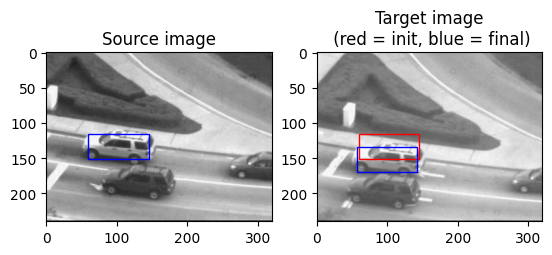

In [ ]:
num_iters = 100
threshold = 0.01
seq = np.load("/content/carseq.npy")
rect = [59, 116, 145, 151]
It = seq[:,:,0]

# Source frame
plt.figure()
plt.subplot(1,2,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')
draw_rect(rect,'b')

# Target frame + LK
It1  = seq[:,:, 20]
plt.subplot(1,2,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image\n (red = init, blue = final)')
p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
rect_t1 = rect + np.concatenate((p,p))
draw_rect(rect,'r')
draw_rect(rect_t1,'b')


## Q2.3: Tracking with template update (15 points)

In [ ]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param seq       : (H, W, T), sequence of frames
    :param rect      : (4, 1), coordinates of template in the initial frame. top-left and bottom-right corners.
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, threshold for terminating the LK optimization
    :return: rects   : (T, 4) tracked rectangles for each frame
    """
    H, W, N = seq.shape

    rects =[rect]
    It = seq[:,:,0]

    # Iterate over the car sequence and track the car
    #for i in range(seq.shape[2]):
    for i in range(1, N):
        # ===== your code here! =====
        # TODO: add your code track the object of interest in the sequence

        # ===== End of code =====

      # Different Frames

      It = seq[:, :, i - 1]
      It1 = seq[:, :, i]
      p = LucasKanade(It, It1, rects[-1], threshold, num_iters)

      # Update Coordinates

      new_rect = [rects[-1][0] + p[0], rects[-1][1] + p[1], rects[-1][2] + p[0], rects[-1][3] + p[1]]
      rects.append(new_rect)

    rects = np.array(rects)
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not ({N}x{4})"
    return rects

### Q2.3 (a) - Track Car Sequence

Run the following snippets. If you have implemented LucasKanade and TrackSequence function correctly, you should see the box tracking the car accurately. Please note that the tracking might drift slightly towards the end, and that is entirely normal.

Feel free to play with these snippets of code by playing with the parameters.

In [ ]:
def visualize_track(seq,rects,frames):
    # Visualize tracks on an image sequence for a select number of frames
    plt.figure(figsize=(15,15))
    for i in range(len(frames)):
        idx = frames[i]
        frame = seq[:, :, idx]
        plt.subplot(1,len(frames),i+1)
        plt.imshow(frame, cmap='gray')
        plt.axis('off')
        draw_rect(rects[idx],'b');

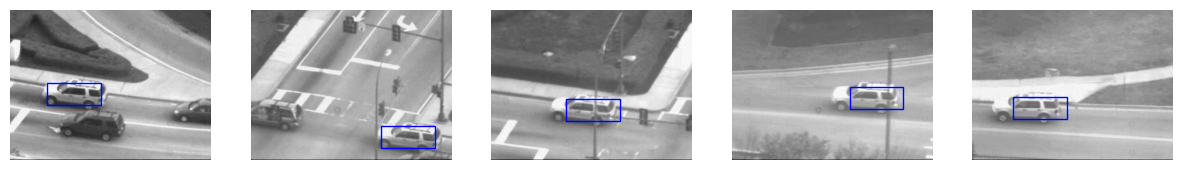

In [ ]:
seq = np.load("/content/carseq.npy")
rect = [59, 116, 145, 151]

# NOTE: feel free to play with these parameters
num_iters = 10000
threshold = 0.1

rects = TrackSequence(seq, rect, num_iters, threshold)

visualize_track(seq,rects,[0, 79, 159, 279, 409])

### Q2.3 (b) - Track Girl Sequence

Same as the car sequence.

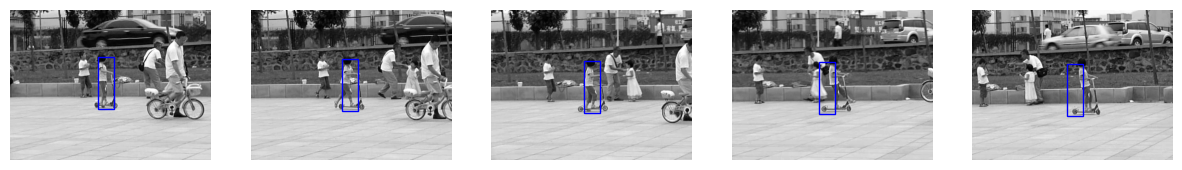

In [ ]:
# Loads the squence
seq = np.load("/content/girlseq.npy")
rect = [280, 152, 330, 318]

# NOTE: feel free to play with these parameters
num_iters = 200
threshold = 0.1

rects = TrackSequence(seq, rect, num_iters, threshold)

visualize_track(seq,rects,[0, 14, 34, 64, 84])